In [1]:
# !pip install yfinance
#!pip install pmdarima
#!pip install arch

In [1]:
# import all the libraries to be used in this notebook
import math
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import yfinance as yf
import plotly.express as px
from pandas.plotting import lag_plot
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import arch
import warnings
warnings.filterwarnings('ignore')

In [2]:
# retrieve stock data from yahoo finance

apple = 'aapl'
df = yf.download(apple, start='2013-01-01', end='2022-12-31')

df.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02 00:00:00-05:00,19.779285,19.821428,19.343929,19.608213,16.862829,560518000
2013-01-03 00:00:00-05:00,19.567142,19.631071,19.321428,19.360714,16.649981,352965200
2013-01-04 00:00:00-05:00,19.177500,19.236786,18.779642,18.821428,16.186197,594333600
2013-01-07 00:00:00-05:00,18.642857,18.903570,18.400000,18.710714,16.090986,484156400
2013-01-08 00:00:00-05:00,18.900356,18.996071,18.616072,18.761070,16.134289,458707200


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02 00:00:00-05:00,19.779285,19.821428,19.343929,19.608213,16.862829,560518000
2013-01-03 00:00:00-05:00,19.567142,19.631071,19.321428,19.360714,16.649981,352965200
2013-01-04 00:00:00-05:00,19.177500,19.236786,18.779642,18.821428,16.186197,594333600
2013-01-07 00:00:00-05:00,18.642857,18.903570,18.400000,18.710714,16.090986,484156400
2013-01-08 00:00:00-05:00,18.900356,18.996071,18.616072,18.761070,16.134289,458707200
...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,130.919998,132.419998,129.639999,131.860001,131.860001,63814900
2022-12-27 00:00:00-05:00,131.380005,131.410004,128.720001,130.029999,130.029999,69007800
2022-12-28 00:00:00-05:00,129.669998,131.029999,125.870003,126.040001,126.040001,85438400


<AxesSubplot:xlabel='Date'>

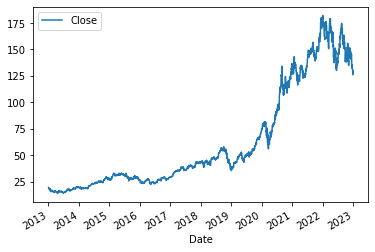

In [4]:
df.plot.line(y="Close", use_index=True)

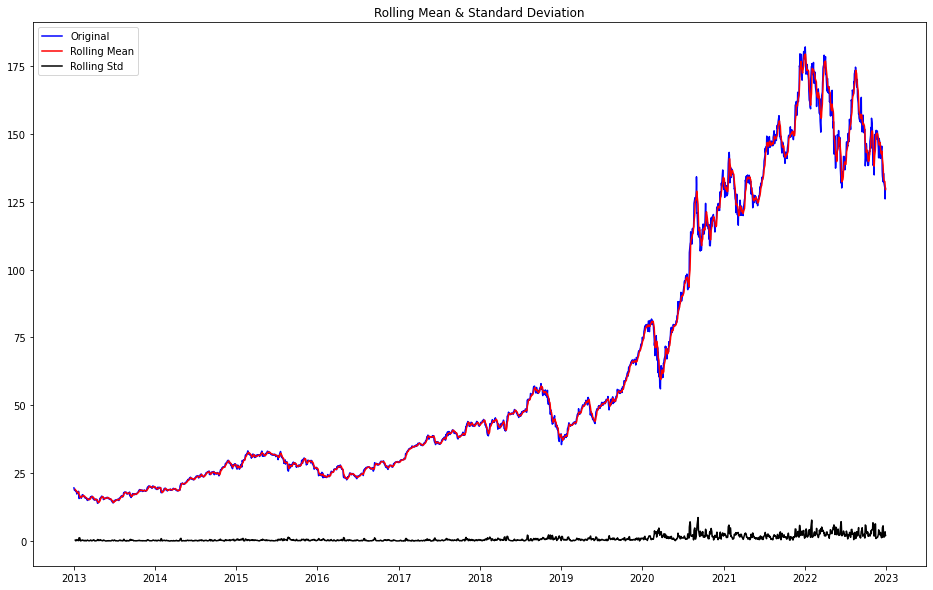

In [5]:
### Model Creation
price = df[["Close"]]
rolLmean = price.rolling(5).mean()
rolLstd = price.rolling(5).std()
#Plot rolling statistics:
fig,ax = plt.subplots(figsize=(16,10))
orig = plt.plot(price, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,62.383387,63.087693,61.696664,62.416599,60.637030,1.713540e+08
std,48.683035,49.322128,48.051043,48.709794,49.248659,1.250498e+08
min,13.856071,14.271429,13.753571,13.947500,12.064586,3.519590e+07
25%,26.971250,27.219376,26.705000,26.983750,24.676630,9.188698e+07
50%,41.353750,41.872499,40.888750,41.313749,39.511665,1.301368e+08
75%,91.272499,92.881876,90.824377,91.526875,90.122934,2.045116e+08
max,182.630005,182.940002,179.119995,182.009995,180.959732,1.460852e+09


Text(0.5, 1.0, 'Apple Daily Returns Over Time')

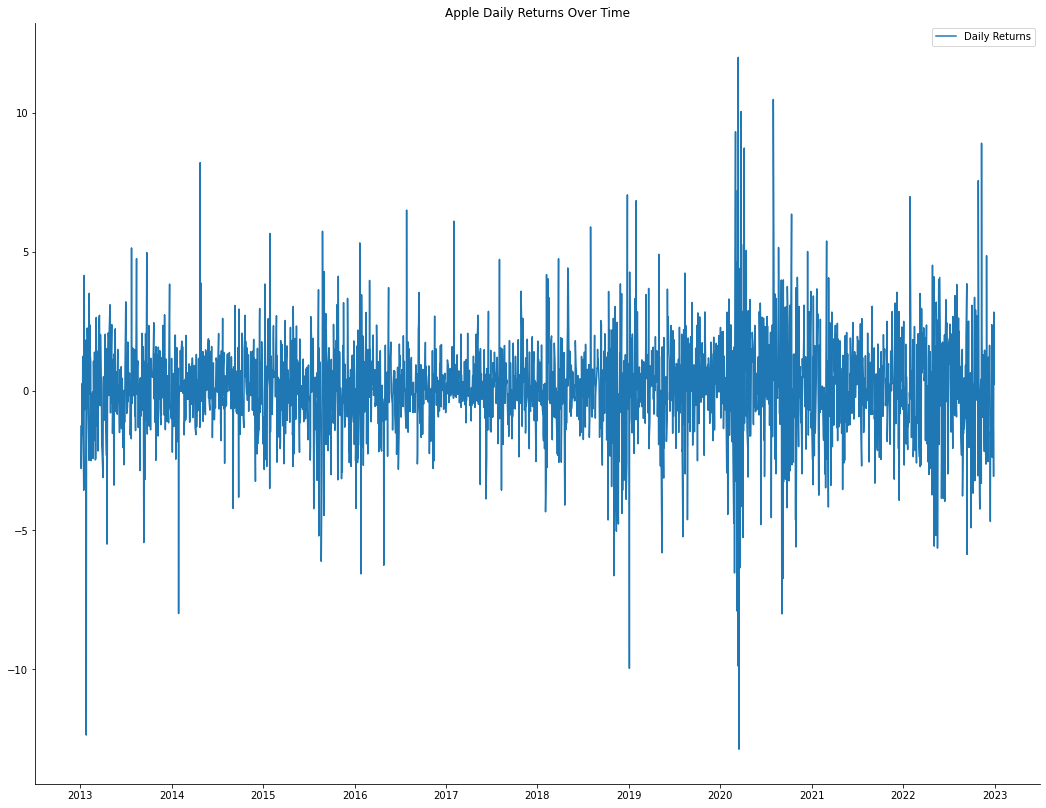

In [7]:
# We get the daily return and plot it
df['Return'] = 100 * (df['Close'].pct_change())
df.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(18,14))
ax.spines[['top','right']].set_visible(False)
plt.plot(df['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Apple Daily Returns Over Time')

In [8]:
#Getting the volatility over time
#We use 21 as the average number of trading days in a month and 252 for a year
daily_volatility = df['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate

print(tabulate([['Apple',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Apple │         1.83         │          8.39          │         29.08         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


In [9]:
# Test for stationarity
# Perform the ADF test
result =adfuller(df['Return'])

# Extract the test statistic and critical values
test_statistic = result[0]
critical_values = result[4]

# Check if the test statistic is greater than the critical value
if test_statistic > critical_values['5%']:
    print("Reject the null hypothesis - Time series is stationary")
else:
    print("Fail to reject the null hypothesis - Time series is not stationary")

Fail to reject the null hypothesis - Time series is not stationary


# USING GARCH

## MODEL SELECTION 
Information Criterion will be used for model selection

I will use Akaike Information Criterion(AIC) or the Bayesian Information Criterion
Forecast the market volatility

In [9]:
#BIC WILL BE USED DUE TO THE FACT THAT IT PLACES MORE PENALTY TO LARGE DATASETS
def fit_garch(p, q):
    model = arch.arch_model(df.Return, mean='constant', vol='GARCH', p=p, q=q)
    results = model.fit()
    bic = results.bic
    return bic


In [10]:
best_bic = np.inf
best_p = 0
best_q = 0
for p in range(1, 5):
    for q in range(1, 5):
        bic = fit_garch(p, q)
        if bic < best_bic:
            best_bic = bic
            best_p = p
            best_q = q

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1727055599736.3894
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13883226299.415688
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6367.282475648998
Iteration:      4,   Func. Count:     29,   Neg. LLF: 5087.169518122164
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4872.580940170663
Iteration:      6,   Func. Count:     43,   Neg. LLF: 4865.27603234719
Iteration:      7,   Func. Count:     48,   Neg. LLF: 4865.217134351835
Iteration:      8,   Func. Count:     53,   Neg. LLF: 4865.209802033583
Iteration:      9,   Func. Count:     58,   Neg. LLF: 4865.20706623417
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4865.205698250531
Iteration:     11,   Func. Count:     68,   Neg. LLF: 4865.205553797395
Iteration:     12,   Func. Count:     73,   Neg. LLF: 4865.2055473622
Iteration:     13,   Func. Count:     77,   Neg. LLF: 4865.205547362804
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2974450828800.214
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1461557947.5861173
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5929.62268053395
Iteration:      4,   Func. Count:     44,   Neg. LLF: 5088.627721965723
Iteration:      5,   Func. Count:     54,   Neg. LLF: 4916.350288146751
Iteration:      6,   Func. Count:     64,   Neg. LLF: 4960.0626845746965
Iteration:      7,   Func. Count:     75,   Neg. LLF: 4881.192592952832
Iteration:      8,   Func. Count:     85,   Neg. LLF: 4863.858415368282
Iteration:      9,   Func. Count:     95,   Neg. LLF: 4863.449345516471
Iteration:     10,   Func. Count:    105,   Neg. LLF: 4863.2748677820655
Iteration:     11,   Func. Count:    115,   Neg. LLF: 4863.331876581673
Iteration:     12,   Func. Count:    125,   Neg. LLF: 4863.179908783578
Iteration:     13,   Func. Count:    134,   Neg. LLF: 4863.179049083101
Iteration:     14,   Func. Count:    143,   Neg. LLF: 4863.178

Iteration:      3,   Func. Count:     33,   Neg. LLF: 5092.112261588938
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4985.009457267238
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5251.550600114754
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4897.75225356862
Iteration:      7,   Func. Count:     76,   Neg. LLF: 4868.115486117622
Iteration:      8,   Func. Count:     86,   Neg. LLF: 4866.12505195178
Iteration:      9,   Func. Count:     96,   Neg. LLF: 4892.890248063761
Iteration:     10,   Func. Count:    107,   Neg. LLF: 4865.338699596648
Iteration:     11,   Func. Count:    116,   Neg. LLF: 4865.7788342592
Iteration:     12,   Func. Count:    126,   Neg. LLF: 4903.494216791112
Iteration:     13,   Func. Count:    137,   Neg. LLF: 4865.0895112590915
Iteration:     14,   Func. Count:    146,   Neg. LLF: 4864.991871874052
Iteration:     15,   Func. Count:    155,   Neg. LLF: 4864.990598625522
Iteration:     16,   Func. Count:    164,   Neg. LLF: 4864.99053950

In [11]:
best_model = arch.arch_model(df.Return, mean='constant', vol='GARCH', p=best_p, q=best_q)
best_results = best_model.fit()
print(best_results.params)
print('p,',best_p)
print('q,',best_q)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1727055599736.3894
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13883226299.415688
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6367.282475648998
Iteration:      4,   Func. Count:     29,   Neg. LLF: 5087.169518122164
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4872.580940170663
Iteration:      6,   Func. Count:     43,   Neg. LLF: 4865.27603234719
Iteration:      7,   Func. Count:     48,   Neg. LLF: 4865.217134351835
Iteration:      8,   Func. Count:     53,   Neg. LLF: 4865.209802033583
Iteration:      9,   Func. Count:     58,   Neg. LLF: 4865.20706623417
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4865.205698250531
Iteration:     11,   Func. Count:     68,   Neg. LLF: 4865.205553797395
Iteration:     12,   Func. Count:     73,   Neg. LLF: 4865.2055473622
Iteration:     13,   Func. Count:     77,   Neg. LLF: 4865.205547362804
Optimization terminated successfully    (Exit mode 0)
            

In [34]:
# forecast the future
apple_forecast = best_results.forecast(horizon = 10)
print(apple_forecast.variance[-1:])

                               h.01      h.02      h.03      h.04      h.05  \
Date                                                                          
2022-12-30 00:00:00-05:00  4.081277  4.047304  4.015021  3.984345  3.955196   

                               h.06     h.07      h.08      h.09      h.10  
Date                                                                        
2022-12-30 00:00:00-05:00  3.927499  3.90118  3.876171  3.852406  3.829825  


Text(0.5, 1.0, 'Rolling Prediction')

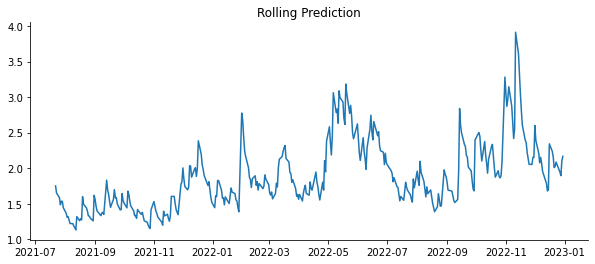

In [26]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = df['Return'][:-(test_size-i)]
    model = arch.arch_model(train, p=best_p, q=best_q)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

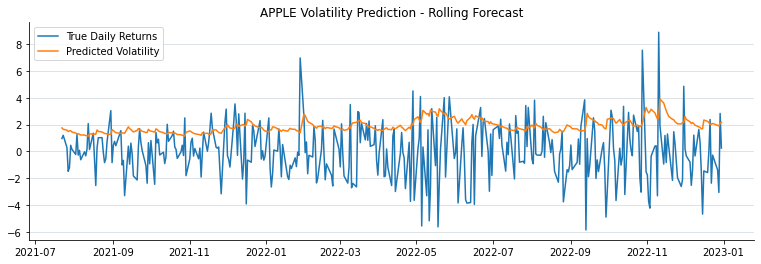

In [27]:
#accuracy
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(df['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('APPLE Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])

In [35]:
from sklearn.metrics import mean_squared_error
# Calculate the mean squared error between the forecasted standard deviations and the actual realized volatility
mse = mean_squared_error(df['Return'][-365:], rolling_predictions)
rmse =  np.sqrt(mse)
# Print the mean squared error
print(rmse)

2.8237464755470647


# ARIMA

In [10]:
#get the monthly mean
monthly_mean = price.Close.resample('M').mean()

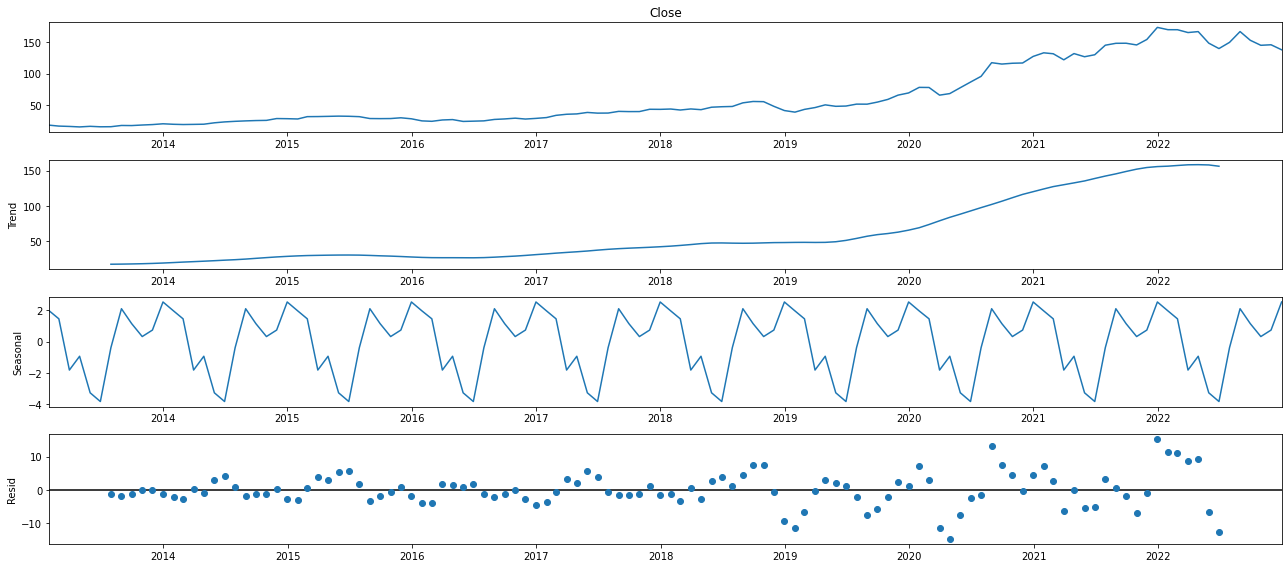

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

From the above data we can see that the data is seasonal

In [ ]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

In [ ]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
# Chceking the forects 
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

##Done

In [87]:
# Fit the ARIMA model
model =auto_arima(price, seasonal=True, suppress_warnings=True, stepwise=True, error_action="ignore", trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9352.997, Time=7.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9360.497, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9354.867, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9354.392, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9360.527, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9355.557, Time=1.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9355.529, Time=1.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9354.698, Time=3.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9349.737, Time=2.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9356.444, Time=1.44 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9352.253, Time=4.94 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=9352.936, Time=5.18 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=9342.429, Time=1.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=9356.386, Time=0.68 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept

In [88]:
# Predict the next 10 time steps
predictions = model.predict(n_periods=10)
print(predictions)

2468    129.422527
2469    129.470133
2470    129.065574
2471    129.508372
2472    129.396646
2473    129.609083
2474    129.481246
2475    129.355579
2476    129.478910
2477    129.279139
dtype: float64


In [97]:
import pmdarima as pm
# Split the data into training and validation sets
# Perform a train-test split
ttrain = price[:int(len(price)*0.8)]
ttest = price[int(len(price)*0.8):]




In [125]:
# Fit the ARIMA model
model =auto_arima(ttrain, start_q=1, max_p=5, max_q=5, start_P=1,  start_Q=1, max_P=2,  max_Q=2, 
                  seasonal=True, suppress_warnings=True, stepwise=True, error_action="ignore", trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7530.510, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=6723.951, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=6469.654, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=6351.436, Time=0.23 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=6222.490, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=6198.672, Time=0.35 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.68 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=2.03 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6200.671, Time=0.60 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 6.800 seconds


In [101]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1974
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -3093.336
Date:                Thu, 09 Feb 2023   AIC                           6198.672
Time:                        13:15:36   BIC                           6232.193
Sample:                             0   HQIC                          6210.989
                               - 1974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9591      0.010    -96.075      0.000      -0.979      -0.939
ar.L2         -0.7292      0.013    -55.964      0.000      -0.755      -0.704
ar.L3         -0.5407      0.012    -44.900      0.000      -0.564      -0.517
ar.L4         -0.3610      0.012    -30.115      0.000      -0.384      -0.338
ar.L5         -0.1149      0.010    -11.898      0.000      -0.134      -0.096
sigma2         1.3482      0.013    101.645      0.000       1.322       1.374
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):             34014.66
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              21.96   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
model_fit=model.fit()
residuals=model_fit.resid

TypeError: fit() missing 1 required positional argument: 'y'

In [111]:
# Predict on the validation set
predictions = pd.DataFrame(model.predict(n_periods=20),index =ttest.index)
predictions.columns = ['Predictions']

In [112]:
predictions.describe()

,Predictions
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [ ]:
# Plot the predictions and real values

plt.plot(ttest, label="Real Values")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()

In [ ]:


# Predict on the validation set
predictions = model.predict(n_periods=len(ttest))

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(ttest, predictions))
print("RMSE:", rmse)

# Plot the predictions and real values
plt.plot(ttest, label="Real Values")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()
    

In [17]:
#I don't think this part is necessary
#df.reset_index(inplace = True)

#df.head()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
 6   Return     2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB


In [19]:
df['MA15'] = df['Close'].rolling(15).mean()
df['MA50'] = df['Close'].rolling(50).mean()

df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,Return,MA15,MA50
Date,,,,,,,,,
2013-03-15 00:00:00-04:00,15.640357,15.865357,15.616071,15.845000,13.705924,643960800,2.580344,15.519452,16.660743
2013-03-18 00:00:00-04:00,15.766071,16.337856,15.757143,16.275715,14.078492,606197200,2.718300,15.550214,16.599043
2013-03-19 00:00:00-04:00,16.410713,16.463215,16.017857,16.231787,14.040490,526775200,-0.269900,15.563357,16.547250
2013-03-20 00:00:00-04:00,16.336430,16.343929,16.056786,16.145714,13.966041,308660800,-0.530274,15.581238,16.495950
2013-03-21 00:00:00-04:00,16.079287,16.356428,16.075001,16.168928,13.986120,383255600,0.143780,15.608214,16.444107


In [20]:
df2 = df.copy()

conditions = [df2['MA15'] > df2['MA50'], 
              df2['MA15'] < df2['MA50']]

choices = [1, 0]

df2['Position']= np.select(conditions, choices)
df2.head()

,Open,High,Low,Close,Adj Close,Volume,Return,MA15,MA50,Position
Date,,,,,,,,,,
2013-03-15 00:00:00-04:00,15.640357,15.865357,15.616071,15.845000,13.705924,643960800,2.580344,15.519452,16.660743,0
2013-03-18 00:00:00-04:00,15.766071,16.337856,15.757143,16.275715,14.078492,606197200,2.718300,15.550214,16.599043,0
2013-03-19 00:00:00-04:00,16.410713,16.463215,16.017857,16.231787,14.040490,526775200,-0.269900,15.563357,16.547250,0
2013-03-20 00:00:00-04:00,16.336430,16.343929,16.056786,16.145714,13.966041,308660800,-0.530274,15.581238,16.495950,0
2013-03-21 00:00:00-04:00,16.079287,16.356428,16.075001,16.168928,13.986120,383255600,0.143780,15.608214,16.444107,0


In [21]:

# First we calculate the daily profit.
df2['Close_Next'] = df2['Close'].shift(-1)
df2['Profit'] = [df2.loc[i, 'Close_Next'] - df2.loc[i, 'Close'] if df2.loc[i, 'Position']==1 else 0 for i in df2.index]

#Then the cumulative profit with cumsum() method
df2['Cum_Profit'] = df2['Profit'].cumsum()

In [22]:
fig = px.line(df2, x='Date', y='Cum_Profit', title='Apple Inc Stock Price Cumulative Profit')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Return', 'MA15', 'MA50', 'Position', 'Close_Next', 'Profit', 'Cum_Profit'] but received: Date

In [ ]:
df3 = df.copy()

fig = px.scatter(x=df3['Close'][:-5], y=df3['Close'][5:], title='Apple Stock Price Lag Plot', labels={'x': 'Price (lag=0)', 'y': 'Price (lag=5)'})
fig.show()

In [ ]:
fig = px.line(df3, x='Date', y='Close', title='Apple Inc Stock Price over time')


fig.show()

In [ ]:
hist_data = [df3.Close]

group_labels = ['Apple Inc']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False)

fig.show()

In [ ]:
X = df3.Close
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary

In [ ]:
X = df3.Close
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))